### Simulations

A total of **64 2d wave simulations** with varying significant wave height (*Hs*) and peak period (*Tp*) have been conducted using my own implementation of [HOSim](https://github.com/VegardBaa/HOSim).

> *HOSim is a numerical wave simulation tool based on the High-Order Spectral (HOS) method. It allows for efficient simulation of nonlinear wave fields with customizable sea state parameters.*

The repository functions similarly to HOS-Ocean and is used here for simulating highly nonlinear wave fields. All training and evaluation data in this project have been generated using this tool, which has taken considerable time to develop and validate.

---

### Predictable Zone

The setup for this machine learning experiment involves a **3000-meter-long spatial domain** and **15 minutes of simulation** of highly nonlinear waves (Hs from 2.5-7.0m and Tp from 10-12s). The specific case used is illustrated in the figure below.

The predictable zone is defined based on a continuous measurement of the wave field over a duration of **T = 60 seconds**, within the spatial interval **x = 0 to x<sub>max</sub> = 2000 meters**.

As seen in the figure, using this measurement it becomes possible to make a prediction in the region **x = 2000 to 2700 meters** after a delay of approximately **140 seconds**. This defines the prediction task used in the machine learning setup.


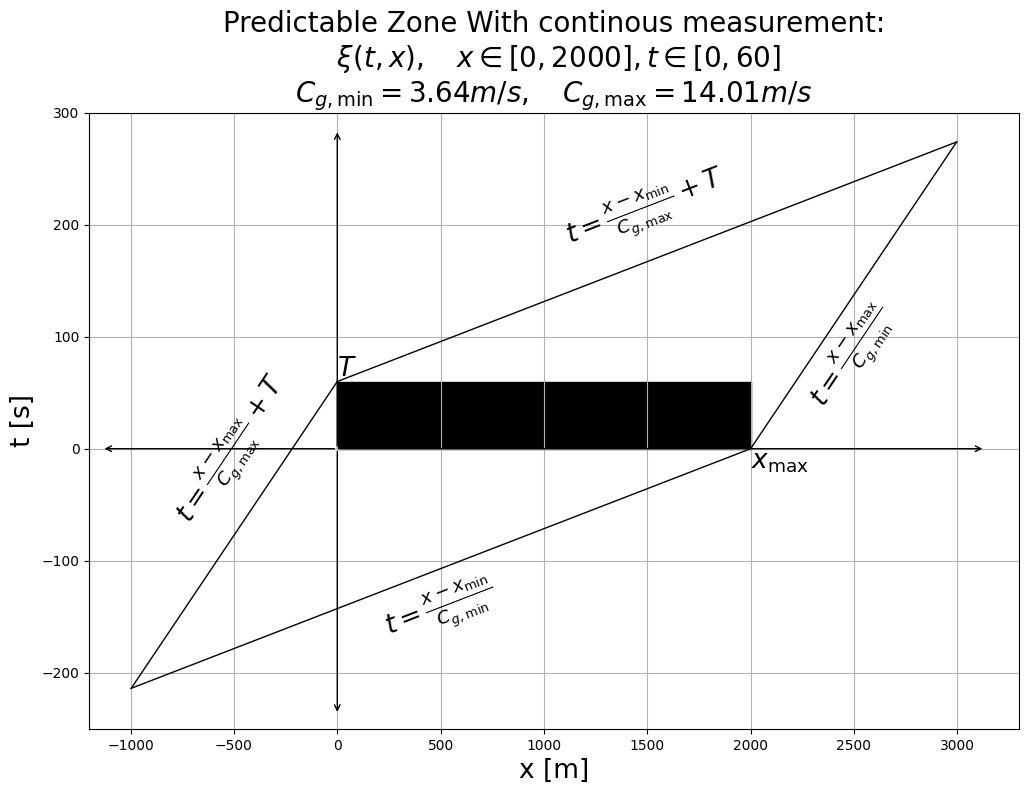

In [117]:
import matplotlib.pyplot as plt
import numpy as np

e_min = 0
e_max = 2000

c_min = 3.64
c_max = 14.01

T = 60

x_min = -1200
x_max = 3300
y_min = -250
y_max = 300

fontsize = 19

x1 = (e_min*c_max - c_min*e_max) / (c_max - c_min) - T * (c_max * c_min) / (c_max - c_min)
t1 = (x1 - e_max) / c_max

x2 = (e_max*c_max - c_min*e_min) / (c_max - c_min) + T * (c_max * c_min) / (c_max - c_min)
t2 = (x2 - e_max) / c_min

points_x = [T, t2, 0, t1, T]
points_y = [e_min, x2, e_max, x1, e_min]

box_x = [T, T, 0, 0] #T]
box_y = [e_min, e_max, e_max, e_min] #, e_min]

equations = [
    fr"$t=\frac{{x - x_{{\max}}}}{{c_{{g,\min}}}}$", 
    r"eq2", 
    r"eq3", 
    r"eq4"
]

equations = [
    fr"$t=\frac{{x - x_{{\min}}}}{{C_{{g,\max}}}} + T$",
    fr"$t = \frac{{x - x_{{\max}}}}{{C_{{g,\min}}}}$", 
    fr"$t = \frac{{x - x_{{\min}}}}{{C_{{g,\min}}}}$", 
    fr"$t=\frac{{x - x_{{\max}}}}{{C_{{g,\max}}}} + T$"
]

fig, ax = plt.subplots(figsize=(12, 8))
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

ax = plt.gca()
transform = ax.transData.transform

for index in range(len(points_x)-1):
    x0, x1 = points_y[index], points_y[index+1]   # matplotlib x-coords
    y0, y1 = points_x[index], points_x[index+1]

    xm = (x0 + x1) / 2
    ym = (y0 + y1) / 2

    # compute angle in degrees for text rotation
    (x0_disp, y0_disp) = transform((x0, y0))
    (x1_disp, y1_disp) = transform((x1, y1))
    angle = np.degrees(np.arctan2(y1_disp - y0_disp, x1_disp - x0_disp))+[0, 180, 180, 0][index]

    # place the equation string
    plt.text(xm, ym, equations[index],
             rotation=angle,
             ha="center", va=["bottom", "top", "top", "bottom"][index],
             fontsize=fontsize)

    plt.plot([x0, x1], [y0, y1], color="k", linewidth=1)
    # plt.plot(box_y[index:index+2], box_x[index:index+2], color="k", linewidth=1)

plt.fill(box_y, box_x, color="k", linewidth=1)

plt.grid()
plt.title("Predictable Zone With continous measurement:\n" + fr" $\xi (t, x), \quad x \in [0, 2000], t \in [0, 60]$" + "\n" + fr"$C_{{g,\min}}={c_min:.2f}m/s, \quad C_{{g,\max}}={c_max:.2f}m/s$", fontsize=20)
plt.ylabel("t [s]", fontsize=fontsize)
plt.xlabel("x [m]", fontsize=fontsize)


# ax.spines['top'].set_visible(False) 
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

plt.text(points_y[0], points_x[0], fr"$T$", ha="left", va="bottom", fontsize=fontsize)
plt.text(points_y[2], points_x[2], fr"$x_{{\max}}$", ha="left", va="top", fontsize=fontsize)
arrowOffset=10
ax.annotate('', xy=(x_max*0.95, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", color='black', lw=1))
ax.annotate('', xy=(0, y_max*0.95), xytext=(0, 0), arrowprops=dict(arrowstyle="->", color='black', lw=1))
ax.annotate('', xy=(x_min*0.95, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", color='black', lw=1))
ax.annotate('', xy=(0, y_min*0.95), xytext=(0, 0), arrowprops=dict(arrowstyle="->", color='black', lw=1))
plt.show()

# jupyter nbconvert ML_update.ipynb --to pdf --PDFExporter.preprocessors="['nbconvert.preprocessors.TagRemovePreprocessor']" --TagRemovePreprocessor.remove_input_tags="['hide_input']"

In [201]:
import sys
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, irfft
from matplotlib.animation import FuncAnimation

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
h5_files = glob.glob(os.path.join("..\\output", "*.h5"))

eta_hat, phi_hat, Hs, Tp, modes, time, length, x = None, None, None, None, None, None, None, None

with h5py.File("Z:\\files\\simulation.h5", "r") as data:
    eta_hat = data["eta_hat"][:]
    phi_hat = data["phi_hat"][:]
    Hs = data["Hs"][:]
    Tp = data["Tp"][:]
    time = data["time"][:]

    modes = data.attrs["modes"]
    length = data.attrs["length"]
    Ta = data.attrs["Ta"]
    x = np.linspace(0, length, 2*modes)

index = np.argmin(np.abs(time - 2*Ta))

eta_hat = eta_hat[:, index:, :]
phi_hat = phi_hat[:, index:, :]
time = time[index:] - time[index]

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from numpy.fft import irfft, rfft

cut_index = np.argmin(np.abs(x-2000))
cut_index_2 = np.argmin(np.abs(x-2700))+1

In [ ]:
# Creating dataset

prediction_time = 280 # 140 sec
measure_time = 120 # one minute
num_measurements = 6
step = int(measure_time / num_measurements)

train_percentage = 0.7
batch_size = 32

X = eta_hat[0, :-prediction_time, :]
y = eta_hat[0, prediction_time+measure_time:, :]

X = irfft(X)
y = irfft(y)

X = X[:, :cut_index]
y = y[:, cut_index:cut_index_2]

# Create dataset using 6 measurements with 10 sec inbetween

X = np.stack([
    X[0*step:-measure_time+0*step-1],
    X[1*step:-measure_time+1*step-1],
    X[2*step:-measure_time+2*step-1],
    X[3*step:-measure_time+3*step-1],
    X[4*step:-measure_time+4*step-1],
    X[5*step:-measure_time+5*step-1],
    X[6*step:-measure_time+6*step-1],
], axis=1)

# Split into train and test

X_train = X[:int(X.shape[0]*train_percentage), :, :]
X_test = X[int(X.shape[0]*train_percentage):, :, :]
y_train = y[:int(y.shape[0]*train_percentage), :]
y_test = y[int(y.shape[0]*train_percentage):, :]

# Only need std to normalize 

std = np.std(X_train)
X_train = X_train / std
y_train = y_train / std

[]


In [ ]:
# X_hat = np.fft.rfft(X)
# X = np.concatenate((np.real(X_hat), np.imag(X_hat)), axis=-1)

# y_train_hat = np.fft.rfft(y)
# y_train = np.concatenate((np.real(y_train_hat), np.imag(y_train_hat)), axis=-1)

# y_pred = np.fft.irfft(y_pred[:, :y_pred.shape[-1]//2] + 1.j * y_pred[:, y_pred.shape[-1]//2:])

In [ ]:
# Creating the model

inputs = keras.Input(shape=(X_train.shape[-2], X_train.shape[-1]))
x_ = layers.Flatten()(inputs)
x_ = layers.Dense(512, activation='relu')(x_)
x_ = layers.Dense(512, activation='relu')(x_)
outputs = layers.Dense(y_train.shape[-1])(x_)

inputs = keras.Input(shape=(X_train.shape[-2], X_train.shape[-1]))  # shape: (timesteps, features)
x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(y_train.shape[-1])(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=1000,
    callbacks=[early_stopping],
    shuffle=True
)

y_pred = model.predict(X_test / std) * std

Epoch 1/1000
28/28 [==============================] - 1s 22ms/step - loss: 0.7564 - mae: 0.6803 - val_loss: 0.6309 - val_mae: 0.6350
Epoch 2/1000
28/28 [==============================] - 0s 16ms/step - loss: 0.4042 - mae: 0.5031 - val_loss: 0.5261 - val_mae: 0.5802
Epoch 3/1000
28/28 [==============================] - 0s 15ms/step - loss: 0.3025 - mae: 0.4353 - val_loss: 0.4602 - val_mae: 0.5436
Epoch 4/1000
28/28 [==============================] - 0s 16ms/step - loss: 0.2486 - mae: 0.3946 - val_loss: 0.4346 - val_mae: 0.5291
Epoch 5/1000
28/28 [==============================] - 0s 17ms/step - loss: 0.2123 - mae: 0.3648 - val_loss: 0.3894 - val_mae: 0.4976
Epoch 6/1000
28/28 [==============================] - 0s 15ms/step - loss: 0.1897 - mae: 0.3451 - val_loss: 0.3734 - val_mae: 0.4900
Epoch 7/1000
28/28 [==============================] - 0s 14ms/step - loss: 0.1629 - mae: 0.3192 - val_loss: 0.3352 - val_mae: 0.4617
Epoch 8/1000
28/28 [==============================] - 1s 18ms/step - 

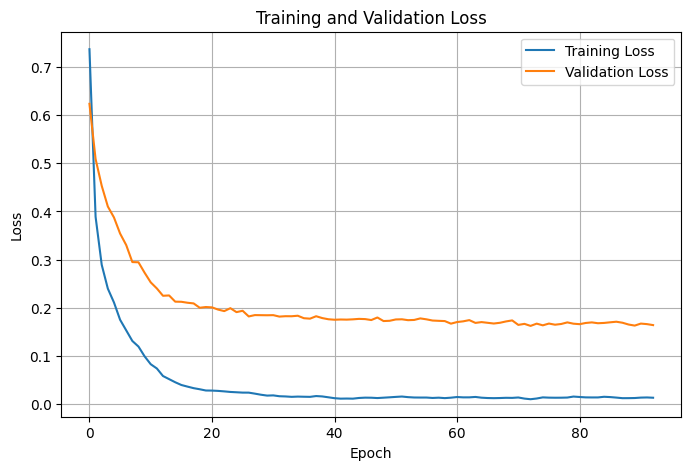

In [233]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()

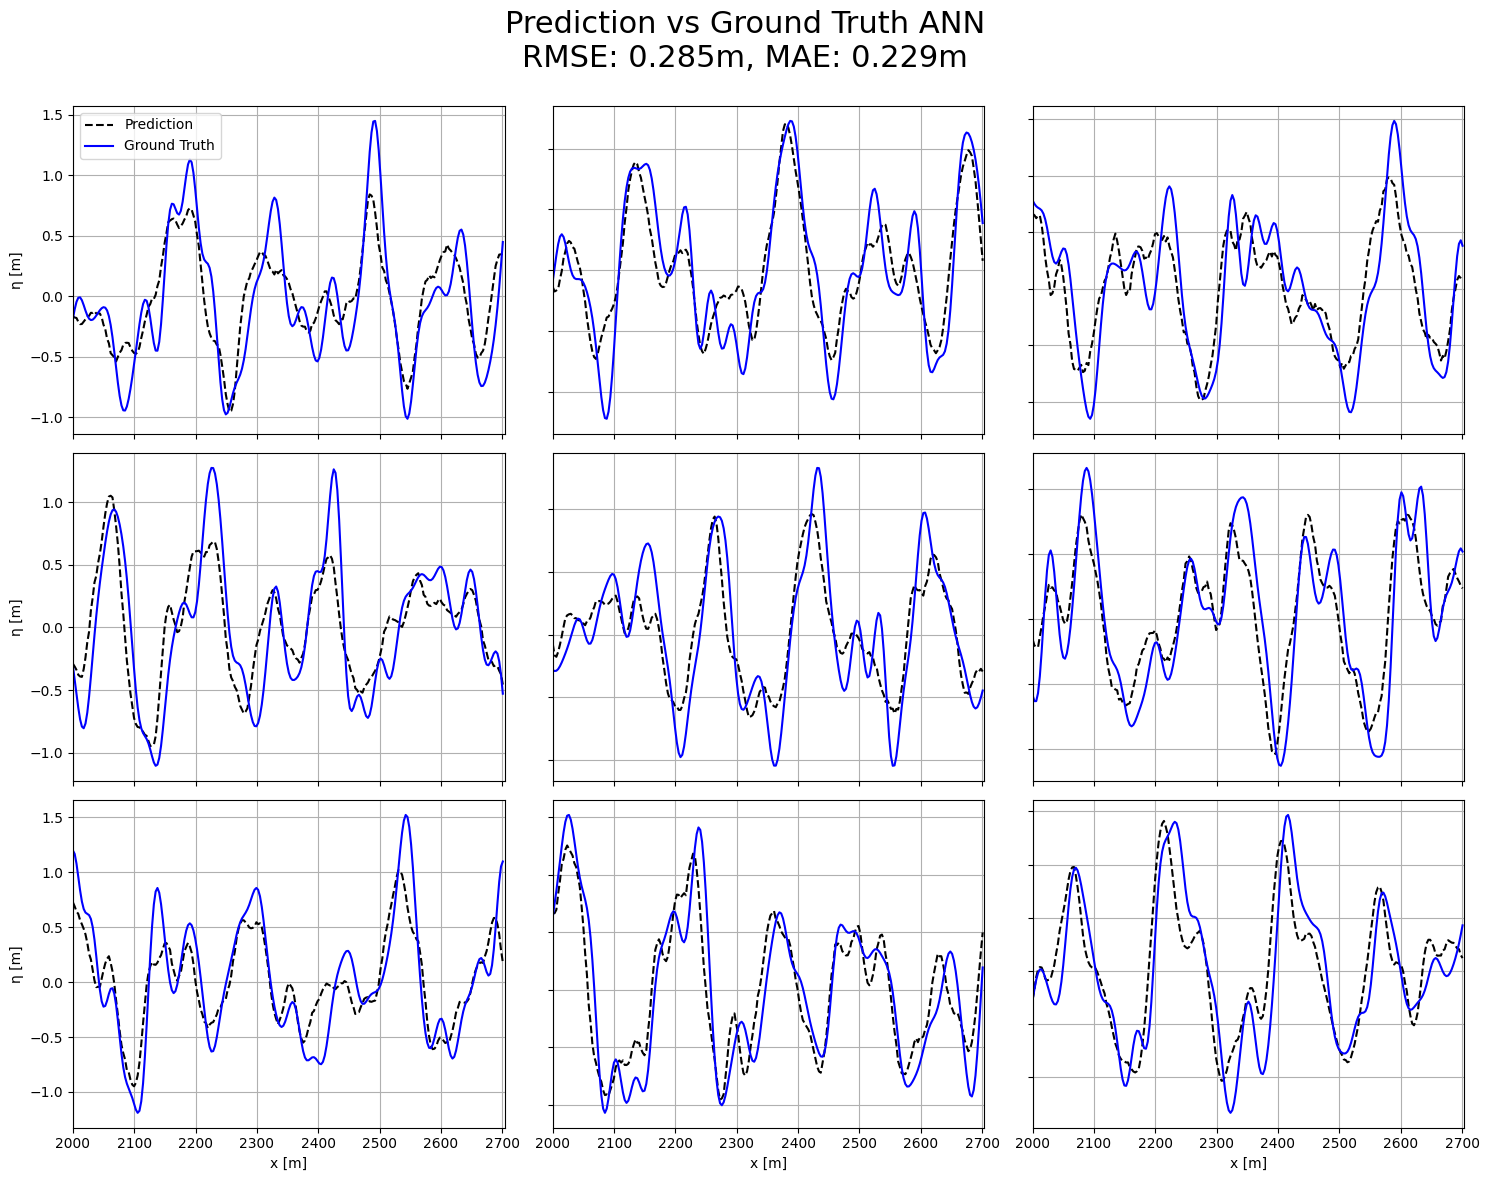

In [237]:
RMSE = np.sqrt(np.mean((y_pred - y_test)**2))
MAE = np.mean(np.abs(y_pred-y_test))

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Prediction vs Ground Truth ANN\n" + f"RMSE: {RMSE:.3f}m, MAE: {MAE:.3f}m", fontsize=22)

for i, ax in enumerate(axes.flat):
    ax.plot(x[cut_index:cut_index_2], y_pred[int(i/9*y_pred.shape[0])], label='Prediction', color="k", linestyle="--")
    ax.plot(x[cut_index:cut_index_2], y_test[int(i/9*y_pred.shape[0])], label='Ground Truth', color="b")
    ax.grid(True)

    ax.grid(True)

    row, col = divmod(i, 3)
    
    if row == 2:
        ax.set_xlabel('x [m]')
    else:
        ax.set_xticklabels([])
    if col == 0:
        ax.set_ylabel('η [m]')
    else:
        ax.set_yticklabels([])

    if i == 0:
        ax.legend()

    ax.set_xlim(x[cut_index], x[cut_index_2])

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

